In [5]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [6]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
#df=pd.read_pickle(os.getcwd()+"\\Data Files\\sql_data.pkl")
# qu1= """
# select * from TMP_BD_GRID_DISTANCE_ID_NEW
# where risk_agrf120 =1 
# """
#df = pd.read_sql(qu1,connection)
#df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.pkl")
#df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.csv")

In [7]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")

In [8]:
# df=pd.read_csv(os.getcwd()+"\Data Files\complete 1.csv")
# df1=pd.read_csv(os.getcwd()+"\Data Files\complete 2.csv")

In [9]:
# df_final = pd.concat([df,df1])
# df_final.drop_duplicates(inplace=True)

In [10]:
# print(df_final.shape)
# print(df.shape)
# print(df1.shape)

In [11]:
# df_final.to_csv(os.getcwd()+"\Data Files\concated.csv")
# del df
# del df_final
# del df1

#df.to_csv(os.getcwd()+"\Data Files\concated.csv")

In [12]:
#df.to_pickle(os.getcwd()+"\Data Files\concated.pkl")

In [13]:
df = pd.read_csv(os.getcwd()+r"\Data Files\final_grids.csv")

In [14]:
df["TIME_DECISION_DATE"] = pd.to_datetime(df["TIME_DECISION_DATE"],format = '%d-%m-%y')
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")

In [15]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE,MONTH_STR
0,97173082,2017-01-01,28.704380,77.062527,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_01815_04683,NaN,2017-01
1,97173083,2017-01-01,19.134879,72.837583,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_00897_02634,NaN,2017-01
2,97173084,2017-01-01,19.253689,73.120929,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_00957_02656,NaN,2017-01
3,97173086,2017-01-01,28.621763,77.055823,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_01813_04665,NaN,2017-01
4,97173087,2017-01-01,28.696583,77.481698,0.0,0.0,0.0,0.0,0.0,NaN,NTC,500_01895_04679,NaN,2017-01


In [16]:
df_summ = df[["RISK_FSTQPD30","MONTH_STR"]].groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

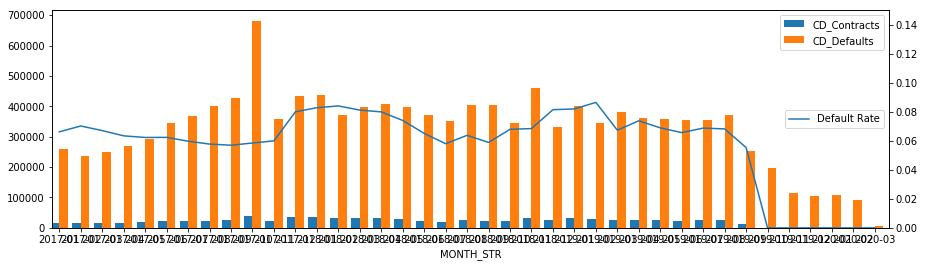

In [17]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [19]:
df[df["TIME_DECISION_DATE"]<=datetime.datetime(2019,7,1)][["RISK_FPD10","RISK_FPD30","RISK_FSPD30","RISK_FSTPD30","RISK_FSTQPD30","RISK_FSTQPD60"]].corr()["RISK_FSTQPD30"]

RISK_FPD10       0.410045
RISK_FPD30       0.378888
RISK_FSPD30      0.575359
RISK_FSTPD30     0.743007
RISK_FSTQPD30    1.000000
RISK_FSTQPD60    0.836501
Name: RISK_FSTQPD30, dtype: float64

# Try FPD10 for MM and validate performance on FSTQPD30

In [20]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 4, 21))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
               (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [21]:
print(df_train.shape)
print(df_test.shape)
df_train.RISK_FPD10.value_counts()

(1391255, 14)
(1078674, 14)


0.0    1338469
1.0      52786
Name: RISK_FPD10, dtype: int64

In [22]:
target = "RISK_FPD10"

Random under-sampling:
1.0    50000
0.0    50000
Name: RISK_FPD10, dtype: int64


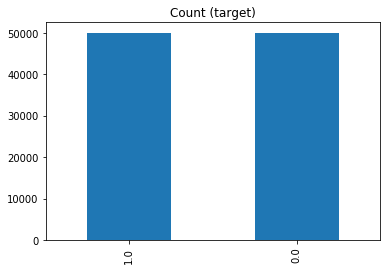

In [23]:
#Downsampling Code 
#count_class_0, count_class_1 = df_train.RISK_FPD10.value_counts()
count_class_0, count_class_1 = (50000,50000)
df_class_0 = df_train[df_train[target] == 0]
df_class_1 = df_train[df_train[target] == 1]
df_class_0_under = df_class_0.sample(count_class_0, random_state = 2)
df_class_1_under = df_class_1.sample(count_class_1, random_state = 2)
df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

print('Random under-sampling:')
print(df_train_under[target].value_counts())

df_train_under[target].value_counts().plot(kind='bar', title='Count (target)');

In [24]:
X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

y_train = df_train_under[target]
y_test =  df_test[target]


In [25]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))


Event rate in train set : 50.00%

Event rate in test set : 3.53%


In [27]:
param_grid = {'n_neighbors': np.arange(1,300,10)
            }
seed = 25

In [28]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(weights = 'uniform')
kfolds = StratifiedKFold(4, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=10,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [29]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..
Randomized search time: 201.12963938713074


In [328]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\ShortTargets_RCV_results_FPD10.csv")

In [30]:
tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')

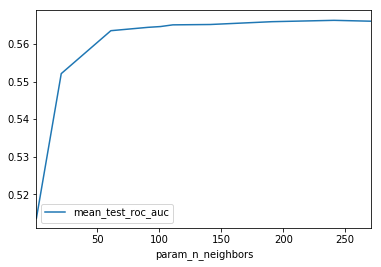

In [31]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors")

In [32]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]]

,param_n_neighbors,mean_test_roc_auc
8,1,0.513750
2,21,0.552120
9,61,0.563527
3,91,0.564421
6,101,0.564628
1,111,0.565079
7,141,0.565172
0,191,0.565922
4,241,0.566279
5,271,0.566047


In [33]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5662794662962735
Best params: 
n_neighbors: 241


In [100]:
param_grid = {'n_neighbors': np.arange(75,300,10)
            }
seed = 25

In [101]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(weights = 'uniform')
kfolds = StratifiedKFold(3, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=6,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [102]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..
Randomized search time: 223.39671349525452


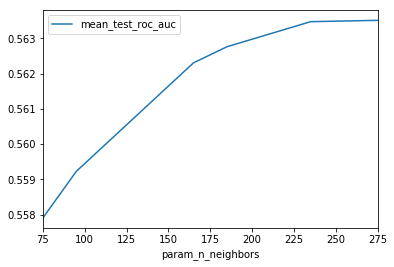

In [103]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\ShortTargets_RCV_results_1.csv")
tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')
tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors")

In [105]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5635119520666667
Best params: 
n_neighbors: 275


In [34]:
#update estimated hyperparameter values to new model
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': 241}
kfolds = StratifiedKFold(4, random_state=1)
knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [35]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [36]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1


In [37]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

GINI TRAIN: 17.57%

GINI TEST: 9.36%

GINI CV: 13.79%


In [38]:
df_train_under['F10_PRED_SCORE'] = ypred_train
df_test['F10_PRED_SCORE'] = ypred_test

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
df_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE,MONTH_STR,F10_PRED_SCORE
10847834,237941809,2019-06-01,10.128995,76.380272,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01579_00624,0.050372,2019-06,0.443983
10847835,237941812,2019-06-01,18.477572,74.020281,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01136_02479,0.031215,2019-06,0.518672
10847836,237941815,2019-06-01,25.280738,82.998425,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_02972_03938,0.119862,2019-06,0.419087
10847837,237941816,2019-06-01,30.561420,76.758889,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01766_05090,0.030451,2019-06,0.352697
10847838,237941818,2019-06-01,30.815237,76.346362,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01689_05147,0.033898,2019-06,0.394191


In [40]:
print("FSTQPD30 Gini: " ,round((2*metrics.roc_auc_score(df_test["RISK_FSTQPD30"],df_test["F10_PRED_SCORE"])-1)*100,2))

FSTQPD30 Gini:  6.26


# Try FPD30 and validate performance on FSTQPD30

In [91]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 4, 1))]
# df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
#               (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [92]:
print(df_train.shape)
print(df_test.shape)
df_train.RISK_FPD30.value_counts()

(1136415, 14)
(1078674, 15)


0.0    1120841
1.0      15574
Name: RISK_FPD30, dtype: int64

In [93]:
target = "RISK_FPD30"

Random under-sampling:
1.0    15000
0.0    15000
Name: RISK_FPD30, dtype: int64


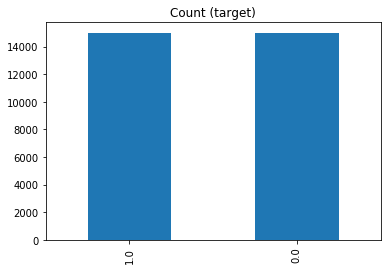

In [94]:
#Downsampling Code 
#count_class_0, count_class_1 = df_train.RISK_FPD10.value_counts()
count_class_0, count_class_1 = (15000,15000)
df_class_0 = df_train[df_train[target] == 0]
df_class_1 = df_train[df_train[target] == 1]
df_class_0_under = df_class_0.sample(count_class_0, random_state = 2)
df_class_1_under = df_class_1.sample(count_class_1, random_state = 2)
df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

print('Random under-sampling:')
print(df_train_under[target].value_counts())

df_train_under[target].value_counts().plot(kind='bar', title='Count (target)');

In [95]:
X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

y_train = df_train_under[target]
y_test =  df_test[target]


In [96]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))


Event rate in train set : 50.00%

Event rate in test set : 1.16%


In [58]:
param_grid = {'n_neighbors': np.arange(1,300,5)
            }
seed = 25

In [59]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(weights = 'uniform')
kfolds = StratifiedKFold(4, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=10,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [60]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..
Randomized search time: 67.57354784011841


In [176]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\ShortTargets_RCV_results_FPD30.csv")

In [61]:
tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')

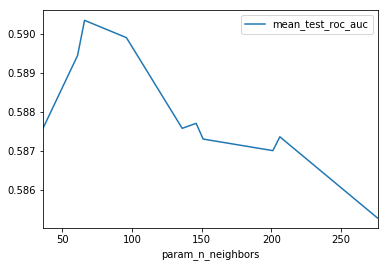

In [62]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors")

In [63]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]]

,param_n_neighbors,mean_test_roc_auc
4,36,0.587556
1,61,0.589438
2,66,0.590339
0,96,0.589896
6,136,0.587573
3,146,0.587701
7,151,0.587299
8,201,0.587002
5,206,0.587356
9,276,0.585277


In [64]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5903386844444444
Best params: 
n_neighbors: 66


In [97]:
#update estimated hyperparameter values to new model
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': 66}
kfolds = StratifiedKFold(4, random_state=1)
knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [98]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [99]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1


In [100]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

GINI TRAIN: 26.42%

GINI TEST: 12.60%

GINI CV: 18.07%


In [101]:
df_train_under['F30_PRED_SCORE'] = ypred_train
df_test['F30_PRED_SCORE'] = ypred_test

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [102]:
df_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE,MONTH_STR,F10_PRED_SCORE,F30_PRED_SCORE
10847834,237941809,2019-06-01,10.128995,76.380272,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01579_00624,0.050372,2019-06,0.443983,0.500000
10847835,237941812,2019-06-01,18.477572,74.020281,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01136_02479,0.031215,2019-06,0.518672,0.484848
10847836,237941815,2019-06-01,25.280738,82.998425,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_02972_03938,0.119862,2019-06,0.419087,0.393939
10847837,237941816,2019-06-01,30.561420,76.758889,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01766_05090,0.030451,2019-06,0.352697,0.333333
10847838,237941818,2019-06-01,30.815237,76.346362,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01689_05147,0.033898,2019-06,0.394191,0.393939


In [103]:
print("FSTQPD30 Gini: " ,round((2*metrics.roc_auc_score(df_test["RISK_FSTQPD30"],df_test["F30_PRED_SCORE"])-1)*100,2))

FSTQPD30 Gini:  4.51


# Try FSPD30 and validate performance on FSTQPD30

In [104]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 1))]
# df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
#               (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [105]:
print(df_train.shape)
print(df_test.shape)
df_train.RISK_FSPD30.value_counts()

(755486, 14)
(1078674, 16)


0.0    733497
1.0     21989
Name: RISK_FSPD30, dtype: int64

In [106]:
target = "RISK_FSPD30"

Random under-sampling:
1.0    20000
0.0    20000
Name: RISK_FSPD30, dtype: int64


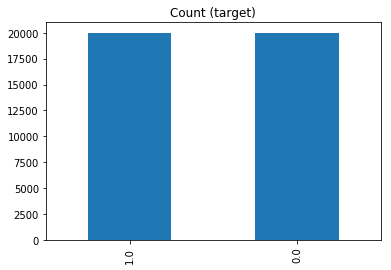

In [107]:
#Downsampling Code 
#count_class_0, count_class_1 = df_train.RISK_FPD10.value_counts()
count_class_0, count_class_1 = (20000,20000)
df_class_0 = df_train[df_train[target] == 0]
df_class_1 = df_train[df_train[target] == 1]
df_class_0_under = df_class_0.sample(count_class_0, random_state = 2)
df_class_1_under = df_class_1.sample(count_class_1, random_state = 2)
df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

print('Random under-sampling:')
print(df_train_under[target].value_counts())

df_train_under[target].value_counts().plot(kind='bar', title='Count (target)');

In [108]:
X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

y_train = df_train_under[target]
y_test =  df_test[target]


In [109]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))


Event rate in train set : 50.00%

Event rate in test set : 2.59%


In [110]:
param_grid = {'n_neighbors': np.arange(1,300,5)
            }
seed = 25

In [72]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(weights = 'uniform')
kfolds = StratifiedKFold(4, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=10,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [73]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..
Randomized search time: 105.58974504470825


In [201]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\ShortTargets_RCV_results_FSPD30.csv")

In [74]:
tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')

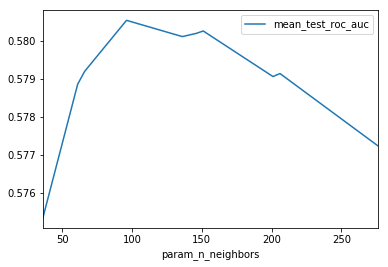

In [75]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors")

In [76]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]]

,param_n_neighbors,mean_test_roc_auc
4,36,0.575344
1,61,0.578869
2,66,0.579206
0,96,0.580549
6,136,0.580121
3,146,0.580206
7,151,0.580269
8,201,0.579068
5,206,0.579148
9,276,0.577250


In [77]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5805493349999999
Best params: 
n_neighbors: 96


In [111]:
#update estimated hyperparameter values to new model
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': 96}
kfolds = StratifiedKFold(4, random_state=1)
knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [112]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [113]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1


In [114]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

GINI TRAIN: 23.13%

GINI TEST: 9.17%

GINI CV: 16.11%


In [115]:
df_train_under['FS30_PRED_SCORE'] = ypred_train
df_test['FS30_PRED_SCORE'] = ypred_test

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
df_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE,MONTH_STR,F10_PRED_SCORE,F30_PRED_SCORE,FS30_PRED_SCORE
10847834,237941809,2019-06-01,10.128995,76.380272,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01579_00624,0.050372,2019-06,0.443983,0.500000,0.479167
10847835,237941812,2019-06-01,18.477572,74.020281,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01136_02479,0.031215,2019-06,0.518672,0.484848,0.500000
10847836,237941815,2019-06-01,25.280738,82.998425,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_02972_03938,0.119862,2019-06,0.419087,0.393939,0.437500
10847837,237941816,2019-06-01,30.561420,76.758889,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01766_05090,0.030451,2019-06,0.352697,0.333333,0.322917
10847838,237941818,2019-06-01,30.815237,76.346362,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01689_05147,0.033898,2019-06,0.394191,0.393939,0.364583


In [117]:
print("FSTQPD30 Gini: " ,round((2*metrics.roc_auc_score(df_test["RISK_FSTQPD30"],df_test["FS30_PRED_SCORE"])-1)*100,2))

FSTQPD30 Gini:  4.54


# Try FSTPD30 and validate performance on FSTQPD30

In [118]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 2, 1))]
# df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
#               (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [119]:
print(df_train.shape)
print(df_test.shape)
df_train.RISK_FSTPD30.value_counts()

(411283, 14)
(1078674, 17)


0.0    391973
1.0     19310
Name: RISK_FSTPD30, dtype: int64

In [120]:
target = "RISK_FSTPD30"

Random under-sampling:
1.0    15000
0.0    15000
Name: RISK_FSTPD30, dtype: int64


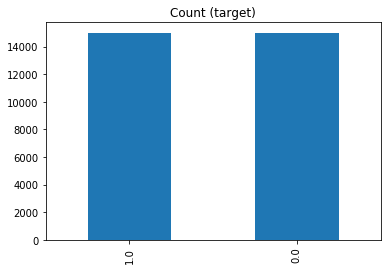

In [121]:
#Downsampling Code 
#count_class_0, count_class_1 = df_train.RISK_FPD10.value_counts()
count_class_0, count_class_1 = (15000,15000)
df_class_0 = df_train[df_train[target] == 0]
df_class_1 = df_train[df_train[target] == 1]
df_class_0_under = df_class_0.sample(count_class_0, random_state = 2)
df_class_1_under = df_class_1.sample(count_class_1, random_state = 2)
df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

print('Random under-sampling:')
print(df_train_under[target].value_counts())

df_train_under[target].value_counts().plot(kind='bar', title='Count (target)');

In [122]:
X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

y_train = df_train_under[target]
y_test =  df_test[target]


In [123]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))


Event rate in train set : 50.00%

Event rate in test set : 4.13%


In [124]:
param_grid = {'n_neighbors': np.arange(1,350,5)
            }
seed = 25

In [125]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(weights = 'uniform')
kfolds = StratifiedKFold(3, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=10,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [86]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..
Randomized search time: 73.21085667610168


In [240]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\ShortTargets_RCV_results_FSTPD30.csv")

In [87]:
tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')

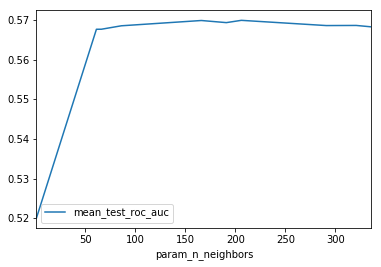

In [88]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors")

In [89]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]]

,param_n_neighbors,mean_test_roc_auc
2,1,0.520033
1,61,0.567646
8,66,0.567656
6,86,0.568524
9,166,0.569856
3,191,0.569322
5,206,0.569899
7,291,0.568580
4,321,0.568611
0,336,0.568258


In [90]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5698986466666667
Best params: 
n_neighbors: 206


In [126]:
#update estimated hyperparameter values to new model
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': 206}
kfolds = StratifiedKFold(4, random_state=1)
knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [127]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [128]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1


In [129]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

GINI TRAIN: 18.13%

GINI TEST: 6.62%

GINI CV: 14.08%


In [130]:
df_train_under['FST30_PRED_SCORE'] = ypred_train
df_test['FST30_PRED_SCORE'] = ypred_test

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [131]:
df_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,GRID_ID,RISK_SCORE,MONTH_STR,F10_PRED_SCORE,F30_PRED_SCORE,FS30_PRED_SCORE,FST30_PRED_SCORE
10847834,237941809,2019-06-01,10.128995,76.380272,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01579_00624,0.050372,2019-06,0.443983,0.500000,0.479167,0.378641
10847835,237941812,2019-06-01,18.477572,74.020281,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01136_02479,0.031215,2019-06,0.518672,0.484848,0.500000,0.475728
10847836,237941815,2019-06-01,25.280738,82.998425,0.0,0.0,0.0,0.0,0.0,0.0,NTC,500_02972_03938,0.119862,2019-06,0.419087,0.393939,0.437500,0.451456
10847837,237941816,2019-06-01,30.561420,76.758889,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01766_05090,0.030451,2019-06,0.352697,0.333333,0.322917,0.427184
10847838,237941818,2019-06-01,30.815237,76.346362,0.0,0.0,0.0,0.0,0.0,0.0,Others,500_01689_05147,0.033898,2019-06,0.394191,0.393939,0.364583,0.407767


In [132]:
print("FSTQPD30 Gini: " ,round((2*metrics.roc_auc_score(df_test["RISK_FSTQPD30"],df_test["FST30_PRED_SCORE"])-1)*100,2))

FSTQPD30 Gini:  3.72


# Try FSTQPD30 and validate performance on FSTQPD30

In [421]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 1, 1))]
# df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
#               (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [422]:
print(df_train.shape)
print(df_test.shape)
df_train.RISK_FSTQPD30.value_counts()

(4699041, 14)
(1078674, 19)


0.0    4359490
1.0     339473
Name: RISK_FSTQPD30, dtype: int64

In [423]:
target = "RISK_FSTQPD30"

Random under-sampling:
1.0    300000
0.0    300000
Name: RISK_FSTQPD30, dtype: int64


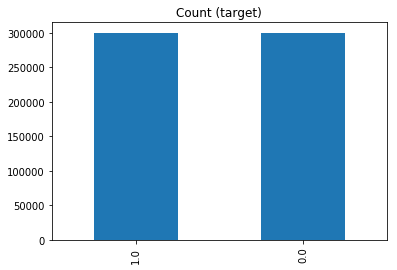

In [424]:
#Downsampling Code 
#count_class_0, count_class_1 = df_train.RISK_FPD10.value_counts()
count_class_0, count_class_1 = (300000,300000)
df_class_0 = df_train[df_train[target] == 0]
df_class_1 = df_train[df_train[target] == 1]
df_class_0_under = df_class_0.sample(count_class_0, random_state = 2)
df_class_1_under = df_class_1.sample(count_class_1, random_state = 2)
df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

print('Random under-sampling:')
print(df_train_under[target].value_counts())

df_train_under[target].value_counts().plot(kind='bar', title='Count (target)');

In [425]:
X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

y_train = df_train_under[target]
y_test =  df_test[target]


In [426]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))


Event rate in train set : 50.00%

Event rate in test set : 6.76%


In [427]:
param_grid = {'n_neighbors': np.arange(1,700,5)
            }
seed = 25

In [429]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(weights = 'uniform')
kfolds = StratifiedKFold(10, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=15,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [430]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..
Randomized search time: 58507.10355305672


In [431]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\ShortTargets_RCV_results_FSTQPD30.csv")

In [432]:
tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')

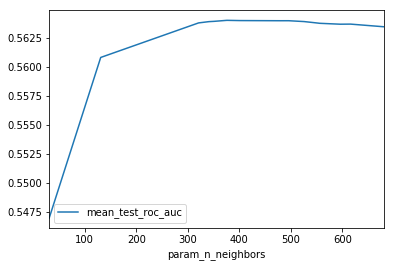

In [433]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors")

In [434]:
tmp1[["param_n_neighbors","mean_test_roc_auc"]]

,param_n_neighbors,mean_test_roc_auc
9,31,0.546987
4,131,0.560793
12,321,0.563762
0,341,0.563872
6,351,0.563897
13,376,0.563984
14,401,0.563963
5,481,0.563949
7,496,0.563950
8,526,0.563877


In [435]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5639836693333333
Best params: 
n_neighbors: 376


In [436]:
#update estimated hyperparameter values to new model
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': 376}
kfolds = StratifiedKFold(4, random_state=1)
knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [437]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [438]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1


In [439]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

GINI TRAIN: 15.15%

GINI TEST: 9.04%

GINI CV: 12.65%


In [440]:
df_train_under['FSTQ30_PRED_SCORE'] = ypred_train
df_test['FSTQ30_PRED_SCORE'] = ypred_test

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [441]:
df_test.head()

,Unnamed: 0,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,RISK_SCORE,MONTH_STR,F30_PRED_SCORE,FS30_PRED_SCORE,FST30_PRED_SCORE,FSTQ30_PRED_SCORE,F10_PRED_SCORE
185665,185665,250244469,2019-08-31,10.042105,76.448236,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.012948,2019-08,0.705882,0.676617,0.628272,0.643617,0.693727
185666,185666,250244475,2019-08-31,30.691595,76.823270,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.072733,2019-08,0.389706,0.402985,0.403141,0.398936,0.383764
185667,185667,250244477,2019-08-31,30.750418,76.796404,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.011748,2019-08,0.529412,0.477612,0.392670,0.390957,0.383764
185668,185668,250244478,2019-08-31,25.774830,73.338201,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.017211,2019-08,0.404412,0.482587,0.570681,0.497340,0.490775
185669,185669,250244481,2019-08-31,30.293438,77.998160,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.041108,2019-08,0.558824,0.547264,0.565445,0.468085,0.575646


In [442]:
print("FSTQPD30 Gini: " ,round((2*metrics.roc_auc_score(df_test["RISK_FSTQPD30"],df_test["FSTQ30_PRED_SCORE"])-1)*100,2))

FSTQPD30 Gini:  9.04


In [443]:
df_test.to_csv(os.getcwd()+"\\all_scores_test_data.csv")

# Combining Scores

In [340]:
df_combined_score=df_test[['RISK_SCORE','F10_PRED_SCORE','F30_PRED_SCORE','FS30_PRED_SCORE',
                           'FST30_PRED_SCORE','FSTQ30_PRED_SCORE','RISK_FSTQPD30','SKP_CREDIT_CASE','TIME_DECISION_DATE']]

In [341]:
df_combined_score.dropna(subset = ['RISK_SCORE'], inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [342]:
df_combined_score["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["RISK_SCORE"]]
df_combined_score["LOGIT_F10_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["F10_PRED_SCORE"]]
df_combined_score["LOGIT_F30_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["F30_PRED_SCORE"]]
df_combined_score["LOGIT_FS30_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["FS30_PRED_SCORE"]]
df_combined_score["LOGIT_FST30_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["FST30_PRED_SCORE"]]
df_combined_score["LOGIT_FSTQ30_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["FSTQ30_PRED_SCORE"]]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [343]:
# pred_list = ['LOGIT_RISK_SCORE','LOGIT_F10_PRED_SCORE','LOGIT_F30_PRED_SCORE','LOGIT_FS30_PRED_SCORE',
#              'LOGIT_FST30_PRED_SCORE','LOGIT_FSTQ30_PRED_SCORE']
pred_list = ['LOGIT_F10_PRED_SCORE','LOGIT_F30_PRED_SCORE','LOGIT_FS30_PRED_SCORE',
            'LOGIT_FST30_PRED_SCORE','LOGIT_FSTQ30_PRED_SCORE']

In [344]:
#Calculate Gini Lift Logistic Regression
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_combined_score[pred_list],df_combined_score["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [345]:
y_pred_comb=comb.predict_proba(df_combined_score[pred_list])[:,1]

In [346]:
metric_auc_combined = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["FSTQ30_PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

In [347]:
print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

gini_combined: 9.21%

gini_knn: 9.08%

gini_hc: 23.00%


In [348]:
print(comb.coef_)
print(comb.intercept_)

[[ 0.06848652  0.06309407 -0.01167015 -0.03306507  0.52242572]]
[-2.60104712]


In [350]:
df_combined_score[pred_list].corr()["LOGIT_FSTQ30_PRED_SCORE"]

LOGIT_F10_PRED_SCORE       0.669609
LOGIT_F30_PRED_SCORE       0.530641
LOGIT_FS30_PRED_SCORE      0.626509
LOGIT_FST30_PRED_SCORE     0.706093
LOGIT_FSTQ30_PRED_SCORE    1.000000
Name: LOGIT_FSTQ30_PRED_SCORE, dtype: float64

In [353]:
df_combined_score["MONTH_STR"]= df_combined_score["TIME_DECISION_DATE"].dt.strftime("%y-%m") 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [387]:
#Check Stability of Combined Model
pred_list = ['LOGIT_RISK_SCORE','LOGIT_F10_PRED_SCORE','LOGIT_F30_PRED_SCORE','LOGIT_FS30_PRED_SCORE',
              'LOGIT_FST30_PRED_SCORE','LOGIT_FSTQ30_PRED_SCORE']
seed = 25522
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(df_combined_score[pred_list],df_combined_score["RISK_FSTQPD30"], test_size=test_size, random_state=seed)


In [388]:
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(X_train[pred_list],y_train)
y_pred_comb_train=comb.predict_proba(X_train[pred_list])[:,1]
y_pred_comb_test=comb.predict_proba(X_test[pred_list])[:,1]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [391]:
metric_auc_combined_train = metrics.roc_auc_score(y_train, y_pred_comb_train)
metric_auc_knn_train = metrics.roc_auc_score(y_train, X_train["LOGIT_FSTQ30_PRED_SCORE"])
metric_auc_hc_train = metrics.roc_auc_score(y_train, X_train["LOGIT_RISK_SCORE"])

metric_auc_combined_test = metrics.roc_auc_score(y_test, y_pred_comb_test)
metric_auc_knn_test = metrics.roc_auc_score(y_test, X_test["LOGIT_FSTQ30_PRED_SCORE"])
metric_auc_hc_test = metrics.roc_auc_score(y_test, X_test["LOGIT_RISK_SCORE"])



gini_combined_train = 2 * metric_auc_combined_train - 1
gini_knn_train = 2 * metric_auc_knn_train - 1
gini_hc_train = 2 * metric_auc_hc_train- 1

gini_combined_test = 2 * metric_auc_combined_test - 1
gini_knn_test = 2 * metric_auc_knn_test - 1
gini_hc_test = 2 * metric_auc_hc_test- 1

print("gini_combined_train:",'{:,.2%}'.format(gini_combined_train))
print("\ngini_knn_train:",'{:,.2%}'.format(gini_knn_train))
print("\ngini_hc_train:",'{:,.2%}'.format(gini_hc_train))

print("\ngini_combined_test:",'{:,.2%}'.format(gini_combined_test))
print("\ngini_knn_test:",'{:,.2%}'.format(gini_knn_test))
print("\ngini_hc_test:",'{:,.2%}'.format(gini_hc_test))


gini_combined_train: 24.19%

gini_knn_train: 9.22%

gini_hc_train: 22.94%

gini_combined_test: 24.29%

gini_knn_test: 8.76%

gini_hc_test: 23.12%


# MOM Gini of Risk Score

In [354]:
#MOM Gini
#Month on Month Gini
df1=df_combined_score
RISK_SCORE = "RISK_SCORE"

import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')
from scoring.metrics import iv,gini,lift

power_tab = []
for j in df1["MONTH_STR"].unique():
    power_tab.append({'Name':j
#                    ,'IV':iv(df1.loc[(df1['MONTH_STR']==j) & (df1['FOUND_FLAG']==1),"RISK_FSTPD30"], df1.loc[(df1['MONTH_STR']==j) & (df1['FOUND_FLAG']==1),"YPRED"])
                    ,'Gini_HC':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTQPD30"], df1.loc[(df1['MONTH_STR']==j),RISK_SCORE])
                    ,'Gini_F10':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTQPD30"], df1.loc[(df1['MONTH_STR']==j),"F10_PRED_SCORE"])        
                    ,'Gini_F30':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTQPD30"], df1.loc[(df1['MONTH_STR']==j),"F30_PRED_SCORE"])        
                    ,'Gini_FS30':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTQPD30"], df1.loc[(df1['MONTH_STR']==j),"FS30_PRED_SCORE"])        
                    ,'Gini_FST30':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTQPD30"], df1.loc[(df1['MONTH_STR']==j),"FST30_PRED_SCORE"])        
                    ,'Gini_FSTQ30':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTQPD30"], df1.loc[(df1['MONTH_STR']==j),"FSTQ30_PRED_SCORE"])                 
                      #                    ,'Lift':lift(df1.loc[(df1['MONTH_STR']==j) & (df1['FOUND_FLAG']==1),"RISK_FSTPD30"], df1.loc[(df1['MONTH_STR']==j) & (df1['FOUND_FLAG']==1),"YPRED"])
                         })
    
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name')
power_out = power_out.sort_values('Name',ascending=True)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mon_gini_short_targets.csv")

,Gini_F10,Gini_F30,Gini_FS30,Gini_FST30,Gini_FSTQ30,Gini_HC
Name,,,,,,
19-06,0.071746,0.056158,0.065384,0.071019,0.095399,0.244382
19-07,0.064856,0.051779,0.057674,0.064178,0.086122,0.213149
19-08,0.072923,0.057765,0.062826,0.069528,0.090129,0.235431


In [445]:
gini(df_combined_score["RISK_FSTQPD30"],df_combined_score["RISK_SCORE"])

0.2299559146174921

In [461]:
df_combined_score["RISK_SCORE"].quantile(0.8)

0.1354710174679411

In [464]:
gini(df_combined_score[df_combined_score["RISK_SCORE"] <= df_combined_score["RISK_SCORE"].quantile(0.7)]["RISK_FSTQPD30"],df_combined_score[df_combined_score["RISK_SCORE"] <= df_combined_score["RISK_SCORE"].quantile(0.7)]["RISK_SCORE"])

0.22303642981519656

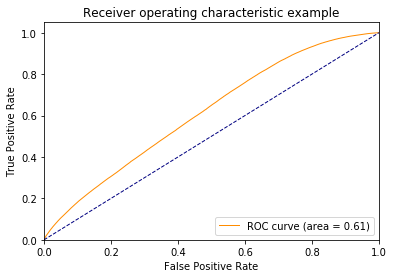

In [465]:
fpr, tpr, thresholds = metrics.roc_curve(df_combined_score["RISK_FSTQPD30"], df_combined_score["RISK_SCORE"])
roc_auc = metrics.auc(fpr, tpr)
plt.figure()

lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [356]:
df.head()

,Unnamed: 0,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FPD10,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,NTC_FLAG,RISK_SCORE,MONTH_STR
0,0,273217442,2019-09-15,26.925771,75.823658,0.0,0.0,0.0,0.0,0.0,0.0,NTC,0.164707,2019-09
1,1,273217520,2019-09-15,28.704617,77.046645,0.0,0.0,0.0,0.0,0.0,0.0,NTC,0.111792,2019-09
2,2,273217523,2019-09-15,11.089342,77.336750,0.0,0.0,0.0,0.0,0.0,0.0,NTC,0.111993,2019-09
3,3,273217525,2019-09-15,19.179927,73.028721,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.018660,2019-09
4,4,273217526,2019-09-15,12.917143,80.192349,0.0,0.0,0.0,0.0,0.0,0.0,Others,0.049166,2019-09


In [375]:
#MOM Gini
#Month on Month Gini
df1=df.dropna(subset = ["RISK_SCORE"])[["RISK_SCORE","RISK_FPD10","RISK_FPD30",
                                       "RISK_FSPD30","RISK_FSTPD30","RISK_FSTQPD30","RISK_FSTQPD60","MONTH_STR"]]
RISK_SCORE = "RISK_SCORE"

import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')
from scoring.metrics import iv,gini,lift

power_tab = []
for j in df1["MONTH_STR"].unique():
    power_tab.append({'Name':j
#                    ,'IV':iv(df1.loc[(df1['MONTH_STR']==j) & (df1['FOUND_FLAG']==1),"RISK_FSTPD30"], df1.loc[(df1['MONTH_STR']==j) & (df1['FOUND_FLAG']==1),"YPRED"])
                    ,'Gini_F10':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FPD10"], df1.loc[(df1['MONTH_STR']==j),RISK_SCORE])        
                    ,'Gini_F30':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FPD30"], df1.loc[(df1['MONTH_STR']==j),RISK_SCORE])        
                    ,'Gini_FS30':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSPD30"], df1.loc[(df1['MONTH_STR']==j),RISK_SCORE])        
                    ,'Gini_FST30':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTPD30"], df1.loc[(df1['MONTH_STR']==j),RISK_SCORE])        
                    ,'Gini_FSTQ30':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTQPD30"], df1.loc[(df1['MONTH_STR']==j),RISK_SCORE])        
                    ,'Gini_FSTQ60':gini(df1.loc[(df1['MONTH_STR']==j),"RISK_FSTQPD60"], df1.loc[(df1['MONTH_STR']==j),RISK_SCORE])        
                     #                    ,'Lift':lift(df1.loc[(df1['MONTH_STR']==j) & (df1['FOUND_FLAG']==1),"RISK_FSTPD30"], df1.loc[(df1['MONTH_STR']==j) & (df1['FOUND_FLAG']==1),"YPRED"])
                         })
    
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name')
power_out = power_out.sort_values('Name',ascending=True)

print("HC SCORE on different delinquencies:")
pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mon_gini_short_targets_hc_performance.csv")

ValueError: continuous format is not supported

In [384]:
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name')
power_out = power_out.sort_values('Name',ascending=True)

print("HC SCORE on different delinquencies:")
pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mon_gini_short_targets_hc_performance.csv")

HC SCORE on different delinquencies:


,Gini_F10,Gini_F30,Gini_FS30,Gini_FST30,Gini_FSTQ30,Gini_FSTQ60
Name,,,,,,
2018-12,0.256943,0.317879,0.306821,0.293691,0.279463,0.306009
2019-01,0.232200,0.310658,0.291864,0.278712,0.263591,0.292517
2019-02,0.230808,0.317527,0.292573,0.272711,0.262214,0.286908
2019-03,0.210412,0.293918,0.265104,0.254410,0.250888,0.268075
2019-04,0.213090,0.277023,0.273908,0.265336,0.262403,0.283961
2019-05,0.216727,0.275410,0.275229,0.272569,0.269246,0.284790
2019-06,0.201487,0.261063,0.254791,0.250288,0.244382,0.263895
2019-07,0.147145,0.193038,0.195669,0.206151,0.213149,0.226075
2019-08,0.182344,0.247015,0.246054,0.232595,0.235431,0.251215


# Check Impact of Training Data Duration



 X = 1
(4699041, 14)
(1078674, 19)
Random under-sampling:
1.0    339473
0.0    339473
Name: RISK_FSTQPD30, dtype: int64
Randomized search..
Randomized search time: 1092.6841881275177
AxesSubplot(0.125,0.125;0.775x0.755)
Best score: 0.5425710426218738
n_neighbors: 336
GINI TRAIN: 15.43%
GINI TEST: 9.02%
GINI CV: 10.27%


 X = 2
(4261124, 14)
(1078674, 19)
Random under-sampling:
1.0    303168
0.0    303168
Name: RISK_FSTQPD30, dtype: int64
Randomized search..
Randomized search time: 1067.301118850708
AxesSubplot(0.125,0.125;0.775x0.755)
Best score: 0.5486814660416683
n_neighbors: 336
GINI TRAIN: 15.66%
GINI TEST: 8.98%
GINI CV: 10.48%


 X = 3
(3889510, 14)
(1078674, 19)
Random under-sampling:
1.0    271905
0.0    271905
Name: RISK_FSTQPD30, dtype: int64
Randomized search..
Randomized search time: 936.3307931423187
AxesSubplot(0.125,0.125;0.775x0.755)
Best score: 0.5527668901473513
n_neighbors: 321
GINI TRAIN: 15.96%
GINI TEST: 8.96%
GINI CV: 11.36%


 X = 4
(3493389, 14)
(1078674, 19)

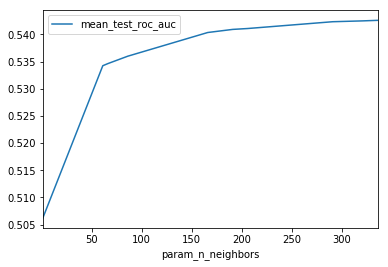

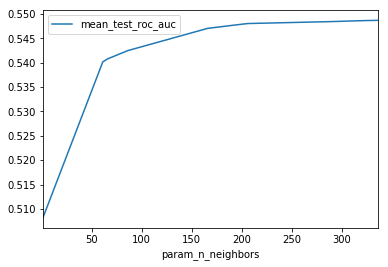

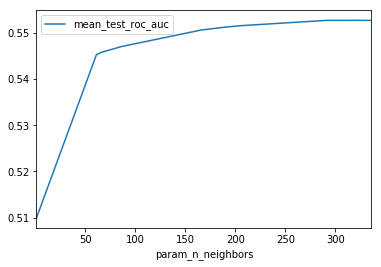

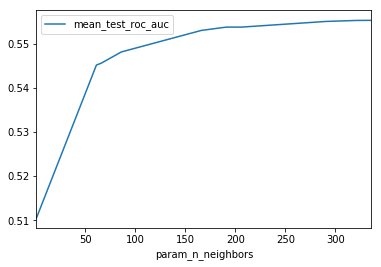

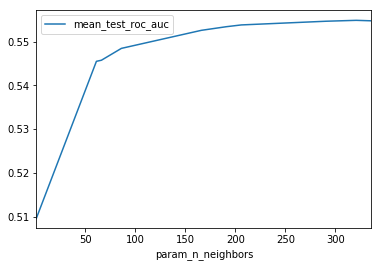

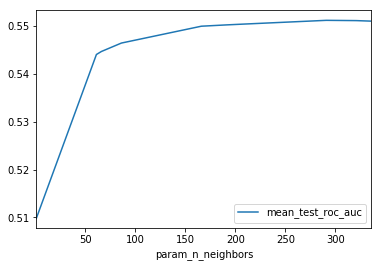

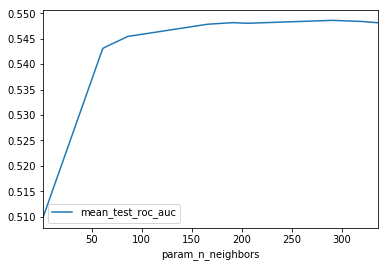

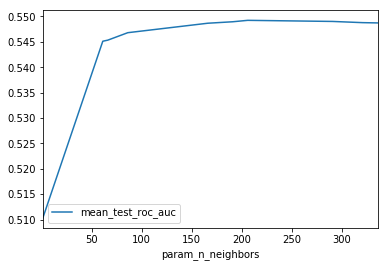

In [412]:
for x in np.arange(1,9,1):
    # Split Train and Test Data Set
    df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, x, 1)) & 
                  (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 1, 1))]
    # df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
    #               (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]
    print('\n\n X =',x)
    print(df_train.shape)
    print(df_test.shape)
    df_train.RISK_FSTQPD30.value_counts()

    target = "RISK_FSTQPD30"

    #Downsampling Code 
    count_class_0, count_class_1 = df_train.RISK_FSTQPD30.value_counts()
    df_class_0 = df_train[df_train[target] == 0]
    df_class_1 = df_train[df_train[target] == 1]
    df_class_0_under = df_class_0.sample(count_class_1, random_state = 2)
    df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)
    print('Random under-sampling:')
    print(df_train_under[target].value_counts())
    #df_train_under[target].value_counts().plot(kind='bar', title='Count (target)');

    X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
    X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
    y_train = df_train_under[target]
    y_test =  df_test[target]

    param_grid = {'n_neighbors': np.arange(1,350,5)
                }
    seed = 25

    from sklearn.neighbors import KNeighborsClassifier
    # Create KNN classifier
    knn = KNeighborsClassifier(weights = 'uniform')
    kfolds = StratifiedKFold(3, random_state=1)

    clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=10,
                             random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


    print("Randomized search..")

    search_time_start = time.time()
    clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
    print("Randomized search time:", time.time() - search_time_start)

    params = clf.best_params_   #get best parameters
    dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
    tmp= pd.DataFrame(dic['params'])
    tmp1= pd.DataFrame(dic)[["param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_n_neighbors')
    print(tmp1[["param_n_neighbors","mean_test_roc_auc"]].plot(x="param_n_neighbors"))

    print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 
    for param_name in sorted(params.keys()):
        print('%s: %r' % (param_name, params[param_name]))

    #update estimated hyperparameter values to new model
    params = {'n_neighbors': params['n_neighbors']}
    kfolds = StratifiedKFold(4, random_state=1)
    knn = KNeighborsClassifier(**params)
    # cross validation gini
    auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                             n_jobs=-1)
    gini_cv = (2 * np.array(auc_cv) - 1).mean()


    bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

    ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
    ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1


    print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
    print("GINI TEST:",'{:,.2%}'.format(gini_test))
    print("GINI CV:",'{:,.2%}'.format(gini_cv))